# CNN + MaxPool
Use the model from CNN_258, but train for fewer epochs.

Observe our best MCC yet.

In [37]:
from datetime import datetime
print(datetime.now())

2023-03-21 16:36:02.695324


In [38]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [39]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=4 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [40]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [41]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [42]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [43]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #cnn3_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #cnn4_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    #cnn.add(cnn2_layer)
    cnn.add(pool1_layer)
    #cnn.add(cnn3_layer)
    #cnn.add(cnn4_layer)
    #cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [44]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-21 16:36:05.651532
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 conv1d_77 (Conv1D)          (None, 4990, 64)          2112      
                                                                 
 max_pooling1d_44 (MaxPoolin  (None, 1246, 64)         0         
 g1D)                                                            
                                                                 
 flatten_33 (Flatten)        (None, 79744)             0         
                                                                 
 dropout_33 (Dropout)        (None, 79744)             0         
                                                                 
 dense_33 (Dense)            (None, 1)                 79745     
                          

## Training

In [45]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [46]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-21 16:36:05.824120
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-21 16:36:11.780632

Training # 1 1
2023-03-21 16:36:11.780771
2023-03-21 16:36:11.780821
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-21 16:36:13.670593


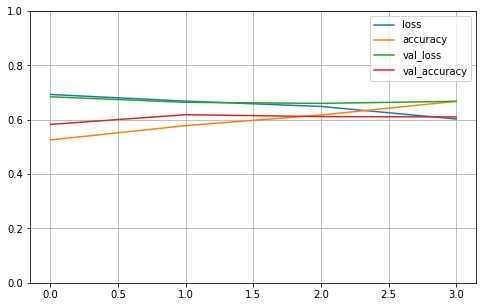


2023-03-21 16:36:20.256672

Testing # 1 1
2023-03-21 16:36:20.257259
2023-03-21 16:36:20.257296
PREDICT
2023-03-21 16:36:20.483832
Test 1:0 458:412 52.64%
Predict 1:0 423:447 48.62%
Test sizes (870, 4997) (870,)
Range of scores: 0.09560629 to 0.935092
Score threshold 0.5
Confusion matrix
 [[260 152]
 [187 271]]
Normalized matrix
 [[0.29885057 0.17471264]
 [0.21494253 0.31149425]]


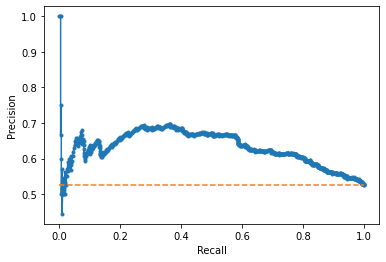

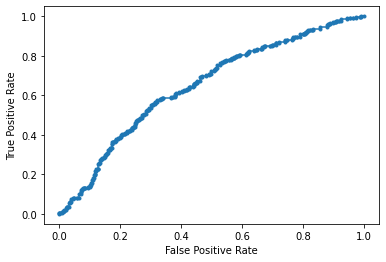

Accuracy: 61.03% Precision: 64.07% Recall: 59.17%
F1: 61.52% MCC: 0.2225
AUPRC: 63.19% AUROC: 64.78%
 accuracy [61.03448275862069]
 precision [64.0661938534279]
 recall [59.1703056768559]
 F1 [61.52099886492621]
 MCC [0.22254410315830797]
 AUPRC [63.18635698216234]
 AUROC [64.77879764276932]
2023-03-21 16:36:21.113858

Training # 1 2
2023-03-21 16:36:21.114639
2023-03-21 16:36:21.114689
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-21 16:36:22.311648


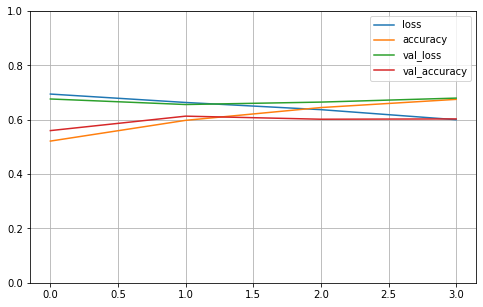


2023-03-21 16:36:29.227931

Testing # 1 2
2023-03-21 16:36:29.228044
2023-03-21 16:36:29.228081
PREDICT
2023-03-21 16:36:29.454582
Test 1:0 442:442 50.00%
Predict 1:0 575:309 65.05%
Test sizes (884, 4997) (884,)
Range of scores: 0.0307186 to 0.9462231
Score threshold 0.5
Confusion matrix
 [[200 242]
 [109 333]]
Normalized matrix
 [[0.22624434 0.27375566]
 [0.12330317 0.37669683]]


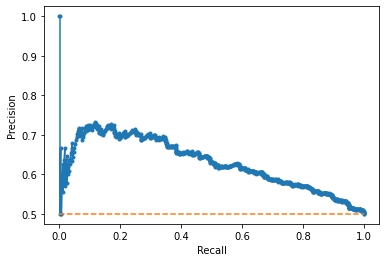

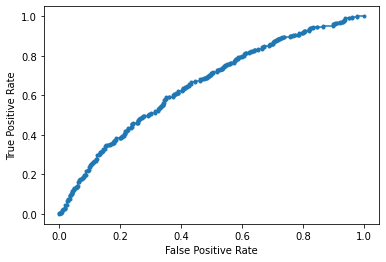

Accuracy: 60.29% Precision: 57.91% Recall: 75.34%
F1: 65.49% MCC: 0.2159
AUPRC: 62.96% AUROC: 65.44%
 accuracy [60.29411764705882]
 precision [57.913043478260875]
 recall [75.3393665158371]
 F1 [65.48672566371681]
 MCC [0.21588786441439237]
 AUPRC [62.961674592261765]
 AUROC [65.43580188775823]
2023-03-21 16:36:30.160898

Training # 1 3
2023-03-21 16:36:30.161415
2023-03-21 16:36:30.161460
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-21 16:36:31.339221


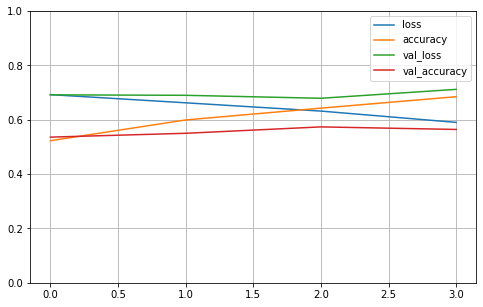


2023-03-21 16:36:37.267417

Testing # 1 3
2023-03-21 16:36:37.267497
2023-03-21 16:36:37.267524
PREDICT
2023-03-21 16:36:37.479725
Test 1:0 442:407 52.06%
Predict 1:0 338:511 39.81%
Test sizes (849, 4997) (849,)
Range of scores: 0.016953748 to 0.88408494
Score threshold 0.5
Confusion matrix
 [[274 133]
 [237 205]]
Normalized matrix
 [[0.32273263 0.15665489]
 [0.27915194 0.24146054]]


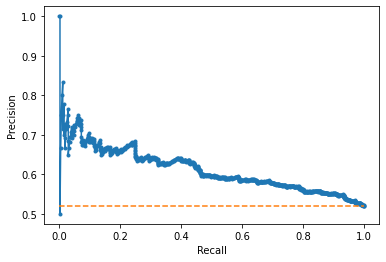

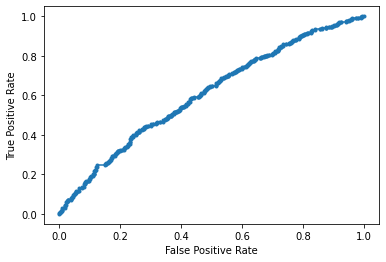

Accuracy: 56.42% Precision: 60.65% Recall: 46.38%
F1: 52.56% MCC: 0.1398
AUPRC: 61.27% AUROC: 60.66%
 accuracy [56.419316843345115]
 precision [60.650887573964496]
 recall [46.380090497737555]
 F1 [52.56410256410257]
 MCC [0.13983702160305417]
 AUPRC [61.266340053969834]
 AUROC [60.664057722881246]
2023-03-21 16:36:38.082550

Training # 1 4
2023-03-21 16:36:38.083511
2023-03-21 16:36:38.083561
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-21 16:36:39.504184


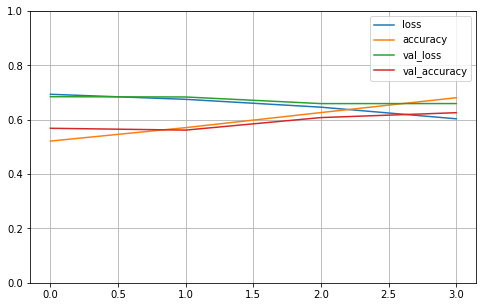


2023-03-21 16:36:46.551582

Testing # 1 4
2023-03-21 16:36:46.551693
2023-03-21 16:36:46.551733
PREDICT
2023-03-21 16:36:46.768431
Test 1:0 459:431 51.57%
Predict 1:0 500:390 56.18%
Test sizes (890, 4997) (890,)
Range of scores: 0.04242761 to 0.92267126
Score threshold 0.5
Confusion matrix
 [[244 187]
 [146 313]]
Normalized matrix
 [[0.2741573  0.21011236]
 [0.16404494 0.35168539]]


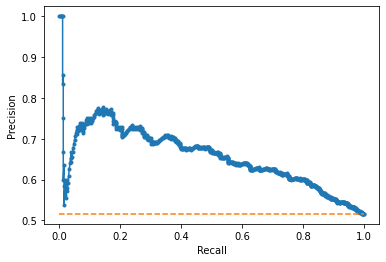

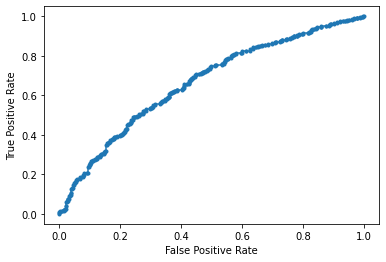

Accuracy: 62.58% Precision: 62.60% Recall: 68.19%
F1: 65.28% MCC: 0.2498
AUPRC: 65.70% AUROC: 66.47%
 accuracy [62.58426966292134]
 precision [62.6]
 recall [68.1917211328976]
 F1 [65.27632950990616]
 MCC [0.24983528462334445]
 AUPRC [65.70152458798518]
 AUROC [66.46649379009145]
2023-03-21 16:36:47.411766

Training # 1 5
2023-03-21 16:36:47.411904
2023-03-21 16:36:47.411958
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-21 16:36:48.581767


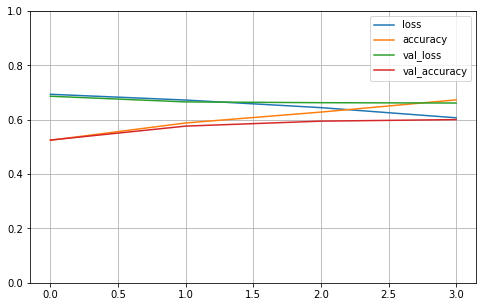


2023-03-21 16:36:54.972567

Testing # 1 5
2023-03-21 16:36:54.975671
2023-03-21 16:36:54.976067
PREDICT
2023-03-21 16:36:55.396229
Test 1:0 457:419 52.17%
Predict 1:0 457:419 52.17%
Test sizes (876, 4997) (876,)
Range of scores: 0.05966382 to 0.9533329
Score threshold 0.5
Confusion matrix
 [[244 175]
 [175 282]]
Normalized matrix
 [[0.27853881 0.19977169]
 [0.19977169 0.32191781]]


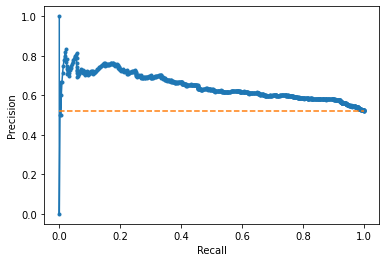

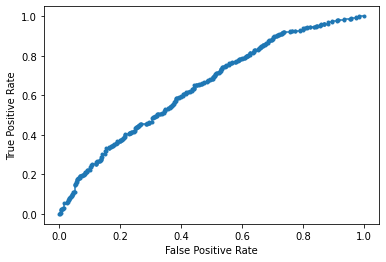

Accuracy: 60.05% Precision: 61.71% Recall: 61.71%
F1: 61.71% MCC: 0.1994
AUPRC: 64.55% AUROC: 64.71%
 accuracy [60.04566210045662]
 precision [61.70678336980306]
 recall [61.70678336980306]
 F1 [61.70678336980306]
 MCC [0.199406735846002]
 AUPRC [64.55491323651533]
 AUROC [64.71488330556761]
2023-03-21 16:36:56.070149

Training # 2 1
2023-03-21 16:36:56.070920
2023-03-21 16:36:56.071927
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-21 16:36:57.239354


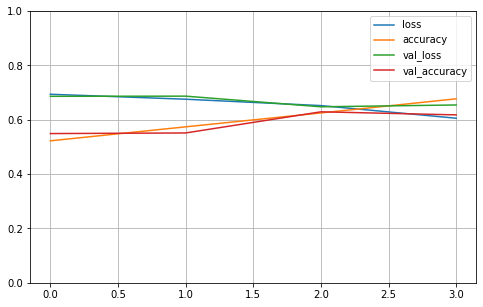


2023-03-21 16:37:03.189828

Testing # 2 1
2023-03-21 16:37:03.189936
2023-03-21 16:37:03.189985
PREDICT
2023-03-21 16:37:03.409366
Test 1:0 472:415 53.21%
Predict 1:0 491:396 55.36%
Test sizes (887, 4997) (887,)
Range of scores: 0.025980035 to 0.91382146
Score threshold 0.5
Confusion matrix
 [[236 179]
 [160 312]]
Normalized matrix
 [[0.26606539 0.20180383]
 [0.18038331 0.35174746]]


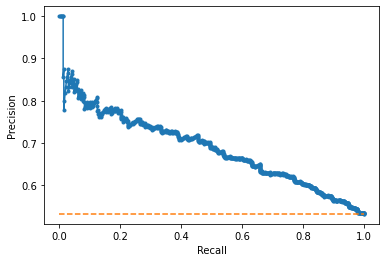

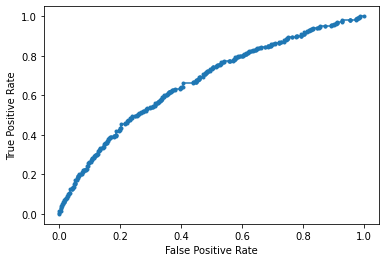

Accuracy: 61.78% Precision: 63.54% Recall: 66.10%
F1: 64.80% MCC: 0.2305
AUPRC: 68.84% AUROC: 66.78%
 accuracy [61.78128523111612]
 precision [63.543788187372705]
 recall [66.10169491525424]
 F1 [64.797507788162]
 MCC [0.23054298517734756]
 AUPRC [68.83520070195628]
 AUROC [66.78068205023484]
2023-03-21 16:37:04.078392

Training # 2 2
2023-03-21 16:37:04.079279
2023-03-21 16:37:04.079330
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-21 16:37:05.226363


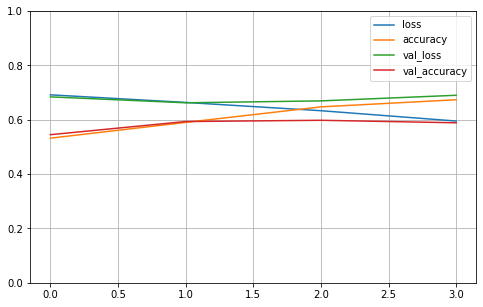


2023-03-21 16:37:16.837808

Testing # 2 2
2023-03-21 16:37:16.839341
2023-03-21 16:37:16.839689
PREDICT
2023-03-21 16:37:17.062839
Test 1:0 452:416 52.07%
Predict 1:0 429:439 49.42%
Test sizes (868, 4997) (868,)
Range of scores: 0.01349858 to 0.8989537
Score threshold 0.5
Confusion matrix
 [[249 167]
 [190 262]]
Normalized matrix
 [[0.28686636 0.19239631]
 [0.21889401 0.30184332]]


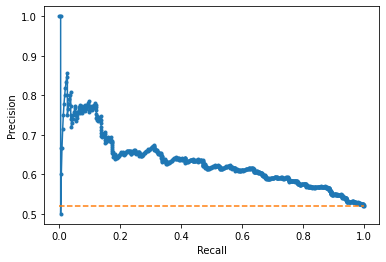

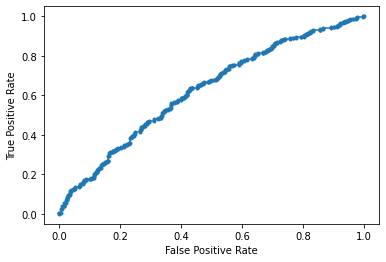

Accuracy: 58.87% Precision: 61.07% Recall: 57.96%
F1: 59.48% MCC: 0.1781
AUPRC: 63.16% AUROC: 62.58%
 accuracy [58.87096774193549]
 precision [61.07226107226107]
 recall [57.9646017699115]
 F1 [59.477866061293994]
 MCC [0.17806219301149911]
 AUPRC [63.1619221621153]
 AUROC [62.57658270932607]
2023-03-21 16:37:17.725150

Training # 2 3
2023-03-21 16:37:17.725300
2023-03-21 16:37:17.725351
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-21 16:37:18.887808


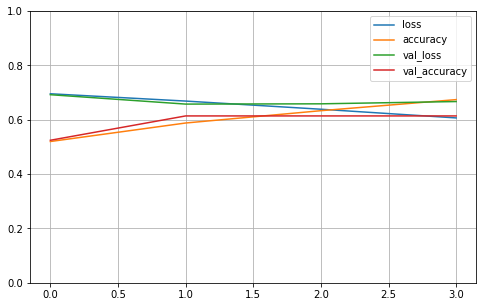


2023-03-21 16:37:26.248556

Testing # 2 3
2023-03-21 16:37:26.248656
2023-03-21 16:37:26.248695
PREDICT
2023-03-21 16:37:26.477038
Test 1:0 453:407 52.67%
Predict 1:0 335:525 38.95%
Test sizes (860, 4997) (860,)
Range of scores: 0.045205206 to 0.927286
Score threshold 0.5
Confusion matrix
 [[300 107]
 [225 228]]
Normalized matrix
 [[0.34883721 0.1244186 ]
 [0.26162791 0.26511628]]


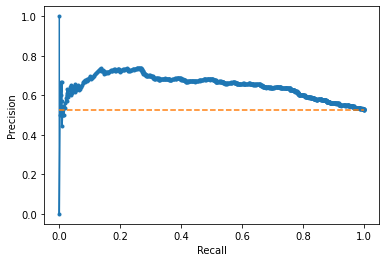

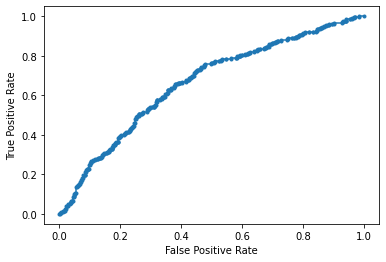

Accuracy: 61.40% Precision: 68.06% Recall: 50.33%
F1: 57.87% MCC: 0.2462
AUPRC: 64.90% AUROC: 66.21%
 accuracy [61.395348837209305]
 precision [68.05970149253731]
 recall [50.331125827814574]
 F1 [57.86802030456853]
 MCC [0.24615030794594742]
 AUPRC [64.89796970857627]
 AUROC [66.20563971557348]
2023-03-21 16:37:27.123529

Training # 2 4
2023-03-21 16:37:27.124678
2023-03-21 16:37:27.124726
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-21 16:37:28.282446


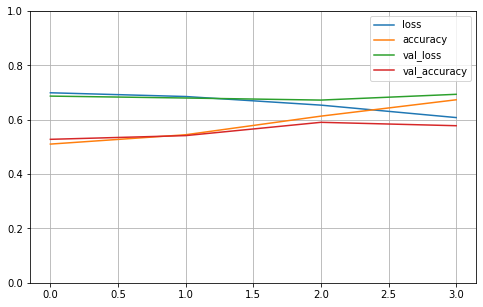


2023-03-21 16:37:39.730807

Testing # 2 4
2023-03-21 16:37:39.730899
2023-03-21 16:37:39.730935
PREDICT
2023-03-21 16:37:39.959235
Test 1:0 432:447 49.15%
Predict 1:0 517:362 58.82%
Test sizes (879, 4997) (879,)
Range of scores: 0.12634216 to 0.9204736
Score threshold 0.5
Confusion matrix
 [[219 228]
 [143 289]]
Normalized matrix
 [[0.24914676 0.25938567]
 [0.16268487 0.32878271]]


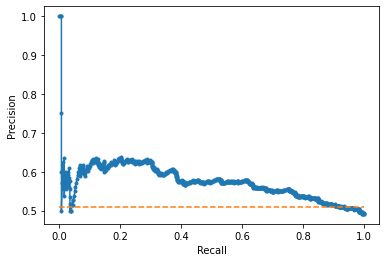

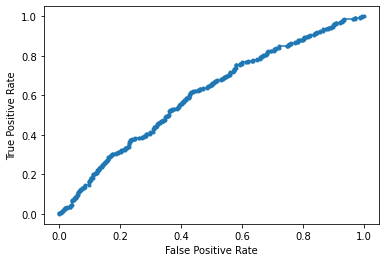

Accuracy: 57.79% Precision: 55.90% Recall: 66.90%
F1: 60.91% MCC: 0.1614
AUPRC: 57.44% AUROC: 60.60%
 accuracy [57.792946530147894]
 precision [55.89941972920697]
 recall [66.89814814814815]
 F1 [60.90621707060063]
 MCC [0.16142070566765]
 AUPRC [57.43761320977126]
 AUROC [60.59791614881102]
2023-03-21 16:37:40.583031

Training # 2 5
2023-03-21 16:37:40.583969
2023-03-21 16:37:40.584017
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-21 16:37:41.999969


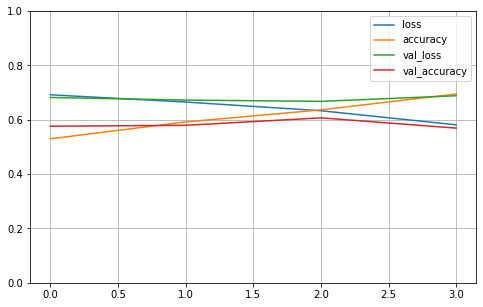


2023-03-21 16:37:49.378034

Testing # 2 5
2023-03-21 16:37:49.378135
2023-03-21 16:37:49.378169
PREDICT
2023-03-21 16:37:49.595726
Test 1:0 449:426 51.31%
Predict 1:0 292:583 33.37%
Test sizes (875, 4997) (875,)
Range of scores: 0.016332764 to 0.90996414
Score threshold 0.5
Confusion matrix
 [[316 110]
 [267 182]]
Normalized matrix
 [[0.36114286 0.12571429]
 [0.30514286 0.208     ]]


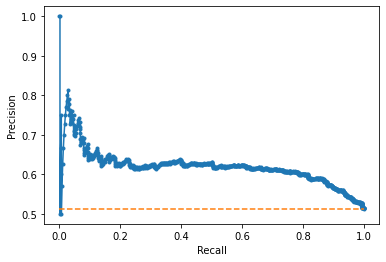

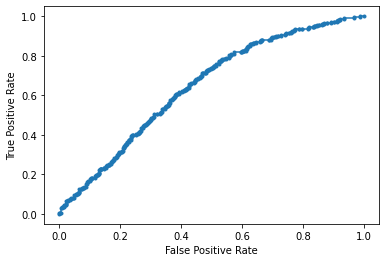

Accuracy: 56.91% Precision: 62.33% Recall: 40.53%
F1: 49.12% MCC: 0.1560
AUPRC: 61.99% AUROC: 64.59%
 accuracy [56.91428571428572]
 precision [62.328767123287676]
 recall [40.53452115812918]
 F1 [49.12280701754387]
 MCC [0.15595571192327057]
 AUPRC [61.994760629351035]
 AUROC [64.5869276535232]
2023-03-21 16:37:50.668907


In [47]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [48]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 59.71% std 2.12
 precision mean 61.78% std 3.33
 recall mean 59.26% std 10.79
 F1 mean 59.87% std 5.43
 MCC mean 0.20% std 0.04
 AUPRC mean 63.40% std 3.00
 AUROC mean 64.28% std 2.26
 accuracy [[61.03448275862069], [60.29411764705882], [56.419316843345115], [62.58426966292134], [60.04566210045662], [61.78128523111612], [58.87096774193549], [61.395348837209305], [57.792946530147894], [56.91428571428572]]
 precision [[64.0661938534279], [57.913043478260875], [60.650887573964496], [62.6], [61.70678336980306], [63.543788187372705], [61.07226107226107], [68.05970149253731], [55.89941972920697], [62.328767123287676]]
 recall [[59.1703056768559], [75.3393665158371], [46.380090497737555], [68.1917211328976], [61.70678336980306], [66.10169491525424], [57.9646017699115], [50.331125827814574], [66.89814814814815], [40.53452115812918]]
 F1 [[61.52099886492621], [65.48672566371681], [52.56410256410257], [65.27632950990616], [61.70678336980306], [64.797507788162], [59.477866061293994